
# Customer Purchase Prediction — End-to-End ML
steps performed
1. **Explore & Clean** the data (handled null values, looked at outlier values, handled duplicate values for Customer_id field)
2. **Preprocess** features (encode `country`, scale numeric features) and **split** data (80/20)
3. **Model** training: Logistic Regression and Random Forest
4. **Evaluate** using Accuracy, Precision, Recall, F1
5. **Pick best model** and **predict** on `customer_visits_predict.csv`


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv("customer_visits_training_data.csv")
df_predict = pd.read_csv("customer_visits_predict.csv")

print("Training shape:", df.shape)
print("Predict (inference) shape:", df_predict.shape)



Training shape: (300, 6)
Predict (inference) shape: (100, 5)


In [3]:
df.head()

,customer_id,age,country,pages_visited,time_spent,purchase
0,CUST186,NaN,India,19,35.16,0
1,CUST153,120.0,US,-3,NaN,0
2,CUST185,120.0,united states,11,1.55,0
3,CUST168,120.0,Inda,12,NaN,1
4,CUST120,120.0,UK,17,NaN,0


In [4]:
df_predict.head()

,customer_id,age,country,pages_visited,time_spent
0,CUST244,-5.0,UK,-3,53.76
1,CUST206,NaN,India,4,27.04
2,CUST255,-5.0,Germany,10,NaN
3,CUST212,120.0,US,-3,40.21
4,CUST207,120.0,Germany,-3,39.67



## 1) Data Exploration & Cleaning

- **age**: fix unrealistic values (clip to [15, 100]) and filled null values with median age
- **pages_visited**: negative values are set to NaN then impute with median; extreame outliers were removed
- **time_spent**: handled missing with median; removed outliers
- **duplicates**: drop exact duplicate rows were deleted


Nulls before cleaning:
 customer_id        0
age               95
country            0
pages_visited      0
time_spent       161
purchase           0
dtype: int64 

Basic describe:


,customer_id,age,country,pages_visited,time_spent,purchase
count,300,205.000000,300,300.000000,139.000000,300.000000
unique,94,NaN,7,NaN,NaN,NaN
top,CUST117,NaN,India,NaN,NaN,NaN
freq,9,NaN,49,NaN,NaN,NaN
mean,NaN,53.746341,NaN,3.623333,31.007122,0.536667
std,NaN,53.589160,NaN,7.986702,17.172271,0.499487
min,NaN,-5.000000,NaN,-3.000000,1.550000,0.000000
25%,NaN,-5.000000,NaN,-3.000000,17.080000,0.000000
50%,NaN,43.000000,NaN,-3.000000,28.110000,1.000000
75%,NaN,120.000000,NaN,11.000000,47.865000,1.000000


Dropped 1 exact duplicate rows.

Nulls after cleaning:
 customer_id      0
age              0
country          0
pages_visited    0
time_spent       0
purchase         0
dtype: int64

Class balance (purchase):
 purchase
1    0.535117
0    0.464883
Name: proportion, dtype: float64


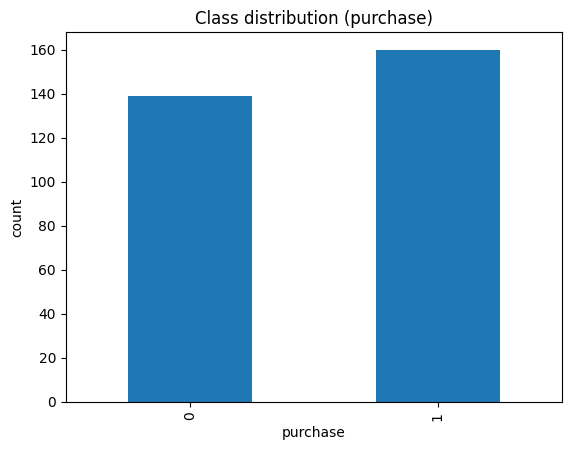

,customer_id,age,country,pages_visited,time_spent,purchase
0,CUST186,41.0,India,11.0,28.11,0
1,CUST153,41.0,United States,11.0,28.11,0
2,CUST185,41.0,United States,11.0,28.11,0
3,CUST168,41.0,India,11.0,28.11,1
4,CUST120,41.0,United Kingdom,11.0,28.11,0


In [5]:

def normalize_country(val: str) -> str:
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    # Common normalizations
    mapping = {
        "us": "United States",
        "u.s.": "United States",
        "usa": "United States",
        "united states": "United States",
        "unitedstates": "United States",
        "america": "United States",
        "india": "India",
        "inda": "India",
        "bharat": "India",
        "uk": "United Kingdom",
        "united kingdom": "United Kingdom",
        "england": "United Kingdom",
        "gbr": "United Kingdom",
    }
    # Try direct mapping first
    if s in mapping:
        return mapping[s]
    # Try some light fixes
    s_simple = s.replace(".", "").replace("-", " ").strip()
    if s_simple in mapping:
        return mapping[s_simple]
    # Title case as default
    return s.title()

def clip_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    return series.clip(lower=low, upper=high)

# Initial EDA
print("Nulls before cleaning:\n", df.isna().sum(), "\n")
print("Basic describe:")
display(df.describe(include='all'))

# Drop exact duplicates
before = len(df)
df = df.drop_duplicates()
print(f"Dropped {before - len(df)} exact duplicate rows.")

# Clean 'age'
if 'age' in df.columns:
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df.loc[(df['age'] < 15) | (df['age'] > 100), 'age'] = np.nan
    df['age'] = df['age'].fillna(df['age'].median())

# Clean 'country'
if 'country' in df.columns:
    df['country'] = df['country'].apply(normalize_country)
    # Bucket very rare countries into "Other" (after normalization)
    value_counts = df['country'].value_counts(dropna=True)
    rare_threshold = max(1, int(0.01 * len(df)))  # 1% or at least 1
    rare_countries = value_counts[value_counts <= rare_threshold].index
    df['country'] = df['country'].apply(lambda x: 'Other' if x in rare_countries else x)
    df['country'] = df['country'].fillna('Other')

# Clean 'pages_visited'
if 'pages_visited' in df.columns:
    df['pages_visited'] = pd.to_numeric(df['pages_visited'], errors='coerce')
    df.loc[df['pages_visited'] < 0, 'pages_visited'] = np.nan
    df['pages_visited'] = df['pages_visited'].fillna(df['pages_visited'].median())
    df['pages_visited'] = clip_iqr(df['pages_visited'], 1.5)

# Clean 'time_spent'
if 'time_spent' in df.columns:
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['time_spent'] = df['time_spent'].fillna(df['time_spent'].median())
    df['time_spent'] = clip_iqr(df['time_spent'], 1.5)

# Ensure target exists and is binary int
assert 'purchase' in df.columns, "Target column 'purchase' not found"
df['purchase'] = pd.to_numeric(df['purchase'], errors='coerce').fillna(0).astype(int)
df['purchase'] = df['purchase'].clip(0,1)

print("\nNulls after cleaning:\n", df.isna().sum())
print("\nClass balance (purchase):\n", df['purchase'].value_counts(normalize=True))

# Simple plot: class balance
plt.figure()
df['purchase'].value_counts().sort_index().plot(kind='bar')
plt.title('Class distribution (purchase)')
plt.xlabel('purchase')
plt.ylabel('count')
plt.show()

display(df.head())



## 2) Preprocessing & Split
- One-hot encode `country`
- Scale numeric features: `age`, `pages_visited`, `time_spent` (Logistic Regression benefits from scaling)
- Train/test split = 80/20 on `purchase`


In [7]:

# Feature/target split
X = df.drop(columns=['purchase'])
y = df['purchase']

# Identify columns
numeric_features = [c for c in ['age', 'pages_visited', 'time_spent'] if c in X.columns]
categorical_features = [c for c in ['country'] if c in X.columns]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (239, 5)  Test size: (60, 5)



## 3) Modeling
We train two models:
- **Logistic Regression** (simple, interpretable baseline)
- **Random Forest** (nonlinear, robust to interactions)
We'll evaluate on Accuracy, Precision, Recall, and F1 (for class 1).


In [8]:

def evaluate_model(name, pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
    }
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    return metrics, pipe

# Pipelines
log_reg = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=20, class_weight='balanced', n_jobs=None))
])

rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, class_weight='balanced_subsample'
    ))
])

results = []
for name, pipe in [('Logistic Regression', log_reg), ('Random Forest', rf)]:
    m, fitted = evaluate_model(name, pipe, X_train, y_train, X_test, y_test)
    results.append((m, fitted))

# Pick best by F1
results_sorted = sorted(results, key=lambda x: x[0]['f1'], reverse=True)
best_metrics, best_model = results_sorted[0]
print("\nBest model by F1:", best_metrics)

# Make a compact results DataFrame
metrics_df = pd.DataFrame([r[0] for r in results]).sort_values('f1', ascending=False).reset_index(drop=True)
display(metrics_df)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.43      0.45        28
           1       0.54      0.59      0.57        32

    accuracy                           0.52        60
   macro avg       0.51      0.51      0.51        60
weighted avg       0.51      0.52      0.51        60

Confusion Matrix:
 [[12 16]
 [13 19]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.36      0.39        28
           1       0.51      0.59      0.55        32

    accuracy                           0.48        60
   macro avg       0.47      0.48      0.47        60
weighted avg       0.48      0.48      0.48        60

Confusion Matrix:
 [[10 18]
 [13 19]]

Best model by F1: {'model': 'Logistic Regression', 'accuracy': 0.5166666666666667, 'precision': 0.5428571428571428, 'recall': 0.59375, 'f1': 0.5671641791044776}


,model,accuracy,precision,recall,f1
0,Logistic Regression,0.516667,0.542857,0.59375,0.567164
1,Random Forest,0.483333,0.513514,0.59375,0.550725



## 4) Predict on `customer_visits_predict.csv`
We apply the **same cleaning** rules to the inference data, then use the **selected best model** to predict `purchase`.


In [10]:

dfp = df_predict.copy()

# Apply same cleaning to inference data
if 'age' in dfp.columns:
    dfp['age'] = pd.to_numeric(dfp['age'], errors='coerce')
    dfp.loc[(dfp['age'] < 15) | (dfp['age'] > 100), 'age'] = np.nan
    dfp['age'] = dfp['age'].fillna(df['age'].median())  # use train median

if 'country' in dfp.columns:
    dfp['country'] = dfp['country'].apply(normalize_country)
    # Map rare to 'Other' using the same rare list from training step
    # Recompute training rare_countries from df step (carried in closure)
    # We reconstruct here consistently:
    train_value_counts = df['country'].value_counts(dropna=True)
    rare_threshold = max(1, int(0.01 * len(df)))
    rare_countries = train_value_counts[train_value_counts <= rare_threshold].index
    dfp['country'] = dfp['country'].apply(lambda x: 'Other' if x in rare_countries else x)
    dfp['country'] = dfp['country'].fillna('Other')

if 'pages_visited' in dfp.columns:
    dfp['pages_visited'] = pd.to_numeric(dfp['pages_visited'], errors='coerce')
    dfp.loc[dfp['pages_visited'] < 0, 'pages_visited'] = np.nan
    dfp['pages_visited'] = dfp['pages_visited'].fillna(df['pages_visited'].median())
    dfp['pages_visited'] = clip_iqr(dfp['pages_visited'], 1.5)

if 'time_spent' in dfp.columns:
    dfp['time_spent'] = pd.to_numeric(dfp['time_spent'], errors='coerce')
    dfp['time_spent'] = dfp['time_spent'].fillna(df['time_spent'].median())
    dfp['time_spent'] = clip_iqr(dfp['time_spent'], 1.5)

# Predict (best_model already includes preprocessing pipeline)
preds = best_model.predict(dfp)
probs = None
try:
    probs = best_model.predict_proba(dfp)[:, 1]
except Exception:
    pass

out = dfp.copy()
out['predicted_purchase'] = preds
if probs is not None:
    out['purchase_probability'] = probs

out_path = "purchase_predictions.csv"
out.to_csv(out_path, index=False)
print("Saved predictions to:", out_path)
display(out.head())


Saved predictions to: purchase_predictions.csv


,customer_id,age,country,pages_visited,time_spent,predicted_purchase,purchase_probability
0,CUST244,41.0,United Kingdom,11.0,28.11,0,0.456710
1,CUST206,41.0,India,11.0,28.11,1,0.511949
2,CUST255,41.0,Germany,11.0,28.11,0,0.462883
3,CUST212,41.0,United States,11.0,28.11,1,0.547116
4,CUST207,41.0,Germany,11.0,28.11,0,0.462883


In [11]:
# Save the trained model as a .pkl file
import joblib

# Assuming `model` is your trained model
joblib.dump(best_model, "best_model.pkl")
print("Model saved as best_model.pkl")

Model saved as best_model.pkl


In [13]:
!pip install streamlit


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\avadlamo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import streamlit

In [15]:
pip show scikit-learn

Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\avadlamo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated packages.
